# Home Assignment No. 4: Part 1 (Practice)
To solve this task, you will write some code to try random **recurrent neural networks** in action. This part of the assignment is a simple practice with pytorch.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [pytorch](http://pytorch.org). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate (sub)problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

## Recurrent Neural Networks

During the seminar, we worked on building an intution for RNNs. We saw that they are very powerful techniques and compared to ARMA methods, where some assumptions must hold to apply the model, RNNs can be applied on sequential data as blackboxes and lead to good results.

Recurrent Neural Networks (RNN) can read inputs $x^{\langle t \rangle}$ one by one. Through the hidden layer activations, they can "remember" some information. The RNN can pass it to the next step, in the case of the unidirectional RNN, or to previous and future steps in the bidirectional RNN.

Before continuing, we should define some notation:
* $[l]$ represents an object associated with the $l^{th}$ layer. 
* Whereas $(i)$ denotes an object associated with the $i^{th}$ example. 

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step. 
    
- **Sub**script $i$ denotes the $i^{th}$ entry of a vector.

Example:  
- $a^{(2)[3]<4>}_5$ denotes the activation of the 2nd training example (2), 3rd layer [3], 4th time step <4>, and 5th entry in the vector.

We first define some functions that will be helpful for us in the next steps:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(axis=0)

The RNN can be intuitively understood as following

<img src="RNN_1.gif" style="width:500;height:300px;">
<caption><center>Figure 1: The Recurrent Neural Network</center></caption>

Let's discuss this implementation more in detail.
## Inputs and outputs of a RNN
We start with the two input vectors of the RNN, the input vector and the hidden state.
### Input $x$
The number of units is represented as $n_x$. It can be understood as the number of units in a single timestep of a single training example.

A timestep in a single input example is represented as $x^{(i) \langle t \rangle }$. The timesteps are indexed as $t$. Normally, a single training example $x^{(i)}$ will consist of multiple time steps $T_x$.

The training examples are grouped into so-called mini batches $x$ of size $m$. Thus, the shape of a mini batch is $(n_x,m,T_x)$. $x$ is thus a 3-dimension tensor and this will be our input into the RNN.

As we will be working with mini-batches of training examples, we will need a 2D slide $x^{\langle t \rangle}$ of the same shape of our mini batch, $(n_x, m)$. In our implementation, this will be the variable `xt`.
### Hidden State $a$
The second input required in a RNN is the hidden state $a^{\langle t \rangle}$, an activation function. The hidden state is passed from one step to the next. It shares similarities with our input vector $x$. 

For example, it has a length $n_{a}$, and if we include a mini-batch of size $m$, the shape of the mini-batch will be $(n_{a},m)$. The hidden state also makes use of the same index $t$ to iterate and on each loop it uses a 2D slice $a^{\langle t \rangle}$ of shape $(n_{a}, m)$.

In our implementation, we will have two variables for the hidden state. They will be called `a_prev` and `a_next`.
Similarly, on each step, we produce an output vector.
### Output $\hat{y}$
The ouput $\hat{y}$ is also a 3D tensor. Its shape is $(n_{y}, m, T_{y})$, where $n_{y}$ represents the number of units in the vector representing the prediction. As it is the case with the input, $m$ reflects the number of examples in the mini batch and $T_{y}$ the number of steps in the prediction. In our implementation, we will be defining this variable as `y_pred`.

If we go more in depth and look at a single time step $t$, we have a 2D slice $\hat{y}^{\langle t \rangle}$ with shape $(n_{y}, m)$. Similarly, the variable in our code for this 2D slice will be called `yt_pred`.
## The RNN cell
In the animation above, we see that the RNN model consists basically of looping over a single cell over the index $t$. As we outlined above, we take the input consisting of two vectors, the current input $x^{\langle t \rangle}$, and the previous hidden state $a^{\langle t - 1\rangle}$. 
At the same time, we will be passing to the next RNN cell two outputs. They are the hidden state  $a^{\langle t \rangle}$ and the prediction $\hat{y}^{\langle t \rangle}$.
Let's start by implementing the RNN cell!
## Task 1. Simple Cell (4 points)
In this task, you will have 4 individual exercises:
* **(1 pt.)** First, start by implementing the hidden state $a$ with the tanh activation function. It is defined as

$$
a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a).
$$

* **(1 pt.)** Second, use the obtained result in the first task to compute the prediction 
$$
\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y).
$$

* **(1 pt.)** Third, proceceed to store the tuple $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in a `accumulator` variable.
* **(1 pt.)** Fourth return `accumulator` and $a^{\langle t \rangle}$ , $\hat{y}^{\langle t \rangle}$.
The function to implement consists of the following arguments:
* `xt` - This is the input data at timestep $t$, a pytorch tensor of shape $(n_x, m)$
* `a_prev` - Hidden state at timestep "t-1", a pytorch tensor of shape $(n_a, m)$
* `parameters` - This is a python dictionary. It consists of five keys:
* - Wax - The weight matrix multiplying the input $x$ with shape $(n_a, n_x)$
* - Waa - The meight matrix multiplying the hidden state $a$ with shape $(n_a, n_a)$
* - Wya - The weight matrix for the hidden-state to the output with shape $(n_y, n_a)$
* - ba -  Represents the bias with shape $(n_a, 1)$
* - by -  Similarly, this is the bias for the hidden-state to the output. It has a shape $(n_y, 1)$
    
The function must return the following variables:
* `a_next` - This is the next hidden state with shape $(n_a, m)$
* `yt_pred` - It is the prediction at timestep $t$ with shape $(n_y, m)$
* `accumulator` - A tuple of values required for the backward pass. The tuple must contain (`a_next`, `a_prev`, `xt`, `parameters`)

In [20]:
def rnn_cell_forward(xt, a_prev, parameters):    

    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    a_next = torch.tanh(Waa @ a_prev + Wax @ xt + ba)
    yt_pred = softmax(Wya @ a_next + by)
    
    return a_next, yt_pred, (a_next, a_prev, xt, parameters)

Let's put our implementation to test! For this, we will define a time series with seasonality using the functions below

Let's also define some variables to control our series

## The RNN Forward Pass
In the previous task, we computed one iteration of a RNN cells. However, the RNN consists of a repetition of RNN cells. For each step in index $t$, we have to use the RNN cell again. 

Let's not forget that on each step, the RNN cell takes two inputs, the current input data $x^{\langle t \rangle}$ and the hidden state from the previous cell, $a^{\langle t-1 \rangle}$. The output, therefore, has to be two vectors, the prediction ($y^{\langle t \rangle}$) and the hidden state ($a^{\langle t \rangle}$). If you remember our previous task, we defined a set of weights and biases named $(W_{aa}, b_{a}, W_{ax}, b_{x})$. They will be used on each time step as well.

Let's implement a forward pass for our RNN!

## Task 2. Go Forward (1+1+1+1+1=5 points)
This task will consist of 5 simple exercises. They are the following:
* **(1 pt.)** First, initializing a 3D array $a$ with zeros. It must have the shape $(n_{a}, m, T_{x})$. This array must store all the hidden states computed by our RNN
* **(1 pt.)** Second, similarly, we will need a 3D array to store the predictions. The array $\hat{y}$ must have the same shape as the array $a$, this means a shape $(n_{y}, m, T_{x})$
* **(1 pt.)** Third, please create the 2D hidden state `a_next`. For this, you must set it equal to $a_{0}$, the initial hidden state.
* **(1 pt.)** Fourth, you must iterate through each step $t$. In each loop, the RNN must do the following:
* - Retrieve $x^{\langle t \rangle}$ with shape $(n_{x}, m)$. This is the 2D slide of $x$ at a time step $t$
* - Call the function `rnn_cell_forward` to update:
* -- the hidden state `a_next` with shape $(n_{a}, m)$
* -- the prediction $\hat{y}^{\langle t \rangle}$
* -- and the accumulator
* - At the $t^{th}$ position:
* -- Store the 2D hidden state in the 3D tensor $a$ with shape $(n_{a}, m, T_{x})$
* -- Store the 2D prediction `yt_pred` with shape $(n_{y}, m)$ in the 3D tensor $\hat{y}_{pred}$ with shape $(n_{y}, m, T_x)$
* - Append the accumulator to a list of accumulators
* - Store the input data `yt_pred` and the list of accumulator into a tuple `acc`
* **(1 pt.)** Fifth, return three variables, the tuple `acc`, the 3D tensor $a$ and $\hat{y}$

Let's remember that to implement the function rnn_forward, we have access to the following variables and parameters:
* `x` - This is the input data for all time steps, a pytorch tensor of shape $(n_x, m, T_x)$
* `a0` - The initial hidden state at timestep "0", a pytorch tensor of shape $(n_a, m)$
* `parameters` - This is a python dictionary. It consists of five keys:
* - Wax - The weight matrix multiplying the input $x$ with shape $(n_a, n_x)$
* - Waa - The meight matrix multiplying the hidden state $a$ with shape $(n_a, n_a)$
* - Wya - The weight matrix for the hidden-state to the output with shape $(n_y, n_a)$
* - ba -  Represents the bias with shape $(n_a, 1)$
* - by -  Similarly, this is the bias for the hidden-state to the output. It has a shape $(n_y, 1)$
    
The function must return the following variables:
* `a` - This is the next hidden state for all time steps with shape $(n_a, m,T_x)$
* `y_pred` - It is the prediction for all time steps with shape $(n_y, m, T_x)$
* `acc` - A tuple of values required for the backward pass. The tuple must contain (list of accumulators, x)

In [21]:
def rnn_forward(x, a0, parameters):
    
    list_accumulators = []
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].size()
    
    a = torch.zeros((n_a, m, T_x))
    y_pred = torch.zeros((n_y, m, T_x))
    a_next = a0.clone()
    
    for t in range(T_x):
        a_next, yt, accum = rnn_cell_forward(x[..., t], a_next, parameters)
        a[..., t] = a_next
        y_pred[..., t] = yt
        list_accumulators.append(accum)
        
    acc = (list_accumulators, x)
    
    
    return a, y_pred, acc
        

## Task 3. Random RNN (1 point)
Now that you have defined `rnn_cell_forward` and `rnn_forward`, let's test it with our data and inspect the results. This task consists of three exercises:
* **(1 pt.)** First, initialize the RNN cell with the `series` provided above with $x$ of shape $(3, 10, 4)$. Remember also to define random values for the hidden layer $a$ and the weights and biases in the dictionary of parameters. Verify the output by printing `y_pred[1]` and the shape of `y_pred`.

In [22]:
def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [23]:
# Config of creating time series
time = np.arange(120, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

We initialize the time series

In [24]:
# Create the time series
series = baseline + trend(time, slope) + seasonality(time,
                                                     period=365,
                                                     amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

and plot it

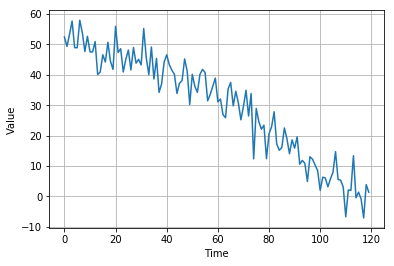

In [25]:
plot_series(time,series)

In [26]:
shapes = {
    'Waa': (7, 7),
    'Wax': (7, 3),
    'Wya': (9, 7),
    'ba': (7, 1),
    'by': (9, 1)
}

x = series.reshape(3, 10, 4)
a0 = torch.randn(size=(7, 10))
parameters = {name : torch.randn(shape) for name, shape in shapes.items()}

In [27]:
a, y_pred, acc = rnn_forward(x, a0, parameters)

print(y_pred[1])
print(y_pred.size())

tensor([[0.0436, 0.0234, 0.0228, 0.2217],
        [0.2358, 0.0438, 0.2363, 0.0436],
        [0.0436, 0.2367, 0.0436, 0.0444],
        [0.2366, 0.0436, 0.0438, 0.0436],
        [0.2110, 0.2361, 0.0436, 0.0436],
        [0.2367, 0.2352, 0.2367, 0.2366],
        [0.0446, 0.0445, 0.0594, 0.2298],
        [0.2254, 0.2367, 0.2365, 0.2367],
        [0.2367, 0.0436, 0.2367, 0.0569],
        [0.2367, 0.2381, 0.2362, 0.2367]])
torch.Size([9, 10, 4])


# Home Assignment No. 4: Part 2 (Theory)
In this part of the homework you are to solve several simple theoretical problems related to time series forecasting algorithms.
* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**.
* Your solution must me **COMPLETE**, i.e. contain all required formulas/proofs/detailed explanations.
* You must write your solution for any problem right after the words **YOUR SOLUTION**. Attaching pictures of your handwriting is allowed, but **highly discouraged**.
## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

## The ARMA Process
The family of ARMA processses (such as ARIMA and SARIMA) plays a major role in times series forecasting. In the first half of the homework, we will look deeper into understanding important elements around ARMA.

We start by remembering that for a time series $\{X_t\}$ with $E(X^2_t) < \infty$, its mean function is defined by $\mu_X(t) = E(X_t)$ and the sample mean, for the $x_1, \ldots, x_n$ observations by $\bar{x} = \frac{1}{n} \sum^n_{t=1} x_t$. 

Similarly, its covariance function is 
$$
\begin{aligned}
\gamma_X(r,s) = Cov(X_r, X_s) \\ 
= E[(X_r - \mu_X(r))(X_s - \mu_X(s))]
\end{aligned}
$$ 
for all integers $r$ and $s$. 

We know that for $\{X_t\}$ to be (weakly) stationary, it must fulfill two conditions. First, $\mu_X(t)$ must be independent of $t$, and $\gamma_X(t+h, t)$ must be also independent of $t$ for each h.

In the seminar, we applied the autocovariance and the autocorrelation functions to a dataset without deeper discussing their definition. Now, we look deeper into them.

#### Autocovariance function
The autocovariance function or ACVF of $\{X_t\}$ at lag $h$ is $\gamma X(h) = Cov(X_{t+h}, X_t)$.

For the observations $x_1, \ldots, x_n$, the sample autocovariance function can be similarly defined by
$$
\begin{aligned}
\hat{\gamma} (h) := n^{-1} \sum^{n - |h|}_{t=1} (x_{t+|h|} - \bar{x})(x_t - \bar{x})
\end{aligned}
$$ 
for $-n < h < n$

#### Autocorrelation function
The autocorrelation function or ACF makes use of ACVF as following $\rho_X(h) = \frac{\gamma X(h)}{\gamma X(0)} = Cor(X_{t+h}, X_t)$.

Similarly, we can write the sample autocorrelation function as 
$$
\begin{aligned}
\hat{\rho} (h) = \frac{\hat{\gamma}(h)}{\hat{\gamma}(0)}
\end{aligned}
$$ 
for $-n < h < n$

Let's also remember a useful property of covariances, the linear property. It means that if that if $EX^2 < \infty ,EY^2 < \infty,EZ^2 < \infty$ and $a$,$b$,and $c$ are any real constants, then, we can do $Cov(aX + bY + c, Z) = a Cov(X, Z) + b Cov(Y, Z)$.

One of the cornerstones of classic forecasting is the Moving Average Process $MA(q)$. It can be defined, if the time series $\{X_t\}$ is $Xt = Z_t + \theta_{1}Z_{t−1} +\ldots+ \theta_{q}Z_{t−q}$, where $\{Z_t\} \sim WN(0,\sigma^2)$, and $\theta_{1},\ldots,\theta_{q}$ are constants, and $WN$, White Noise, being a sequence of uncorrelated random variables, each with zero mean and variance $\sigma^2$ defined by $\sigma^2 = E(X − \mu)^2$. 

Let's put this into practice!

## Task 1. MA(2) (1+1+1=3 points)
Let's define a MA(2) with a white noise function of mean 0 and variance 1. Please do the following (**explicitly** outline all your computations):
* **(1 pt.)** For $\theta = 0.9$, derive the formula for the autocovariance and autocorrelation functions for this process.
* **(1 pt.)** For $\theta = 0.9$, compute the variance of the sample mean $(X_1 + X_2 + X_3 + X_4)/4$.
* **(1 pt.)** If now we change our $\theta$ to $-0.9$, what happens? What is the effect of a negative covariance? Please compare the result with the previous computation and **provide an explanation**.
### Your Solution:

#### 1

$$
MA(2) \implies \{X_t\} = Z_t + \Theta_1Z_{t-1} + \Theta_2Z_{t - 2}
$$

But it was stated in discussions, that we can assume $\Theta_1 = 0$ and have $$\{X_t\} = Z_t + \Theta_2Z_{t - 2}$$

The first case is when Covariance equals Variance (h = 0):
$$
Cov(X_{t + 0}, X_t) = Var(X_t) = Var(Z_t + \Theta_2Z_{t - 2}) = Var(Z_t) + Var(\Theta_2Z_{t - 2}) = \sigma^2 + \Theta^2\sigma^2 = (1 + \Theta^2)\sigma^2  = 1.81 \sigma^2
$$

The second case, h = 2 (and nearly the same for h = -2)
We can say up front that covariances with non-similar indexes will result in zero due to the independence.
Thus we would have

$$
Cov(X_{t + 2}, X_{t}) =  \Theta_2 Cov(Z_{t}, Z_{t}) + 0 = \Theta\sigma^2 = 0.9\sigma^2
$$

The third case is h not in {0, 2, -2}. In such situations the value of $Cov(X_{t+h}, X_t)$ would be zero, due to the fact, that there won't be any parts in the form $Cov(Z_i, Z_j), i = j$.

Now we need to calculate autocorrelation $\rho_X(h) = \frac{\gamma X(h)}{\gamma X(0)} = Cor(X_{t+h}, X_t)$:

$$Cor(X_{t + h}, X_t) = \frac{Cov(X_{t + h}, X_t)}{Cov(X_t, X_t)}$$
In case h = 0, $Cor(X_{t + h}, X_t) = 1$
In case h = +-2, 
$$ 
Cor(X_{t + h}, X_t) = \frac{Cov(X_{t + 2}, X_t)}{Cov(X_t, X_t)} = \frac{\Theta\sigma^2}{(1 + \Theta^2)\sigma^2} = \frac{\Theta}{1 + \Theta^2} = \frac{0.9}{1.81} \approx 0.4972
$$
Zero otherwise

#### 2

$Var \left(\frac{X_1 + X_2 + X_3 + X_4}{4}\right) 
= \frac{1}{16}Var\left(X_1 + X_2 + X_3 + X_4\right) 
= \frac{1}{16}Cov\left(X_1 + X_2 + X_3 + X_4, X_1 + X_2 + X_3 + X_4\right)
$

We know that only lags 0 and 2 are correlated, thus


$
Var \left(\frac{X_1 + X_2 + X_3 + X_4}{4}\right) = \frac{1}{16} \left(4(1 + \Theta^2)\sigma^2 + 4\Theta\sigma^2 \right) = \frac{1}{4}\sigma^2\left( 1 + \Theta + \Theta^2\right) = 0.6775\sigma^2
$

#### 3
With $\Theta = -0.9$ there will be a change in value of $Cov(X_{t+2}, X_{t}) = -0.9\sigma^2$.
Thus previous expression would take form $$\frac{1}{4}\sigma^2\left(1 + \Theta + \Theta^2\right) = 
\frac{1}{4}\sigma^2\left(0.1 + 1.81\right) = 0.4775\sigma^2
$$

We can see, that changing the covariance sign reduced the variance of the sample mean. May be in this case some variables will be cancelling other and because of that, the final variance will be smaller.

## Task 2. Stationary processes (1+1=2 points)
Assume that $\{Y_t\}$ represents a sequence with zero mean and variance $\sigma^2$, let $a$ and $b$ are two constants. Are the following processes stationary? If they are, what would be their respective autocovariance and mean? 
* **(1 pt.)** $b + aY_0$
* **(1 pt.)** $Y_{t}Y_{t-1}$

Explicitly clarify your answer and please provide all necessary steps behind your reasoning.
### Your Solution:

The weak stationality property states that the expectation is constant and the covariance depends only on difference between two time steps:
1. $E(X_{t + h}) = E(X_{t})$
2. $Cov(X_{t + h}, X_t) = Cov(X_{t + h + n}, X_{t + n})$

- $E[b + aY_0] = E[b] + 0 = b$ -- expectation of constant
  
  $Cov[X_{t+h}, X_t] = Cov[b + aY_0, b + aY_0] = Var[b] + 2cov[ab, Y_0] + a^2Var[Y_0] = 0 + 0 + a^2\sigma^2$
  So, this process is weakly stationary as there is no dependence on time

- $ E[X_t] = E[Y_tY_{t - 1}] = \{\text{independence}\} = E[Y_t]E[Y_{t - 1}] = 0$

$Cov[X_{t+h}, X_t] = Cov[X_t, X_{t + h}] = Cov[Y_tY_{t-1}, Y_{t + h}Y_{t - 1 + h} ]$

Using calculation above,

$Cov[Y_tY_{t-1}, Y_{t + h}Y_{t - 1 + h}] = E[Y_tY_{t-1}]E[Y_{t + h}Y_{t - 1 + h}] = E[Y_tY_{t-1}Y_{t + h}Y_{t - 1 + h}]$
  
We know, that variables at different time steps are independend and have zero mean, thus we would get non-zero result from previous calculation only in case when h = 0:

$Cov[Y_tY_{t-1}, Y_{t + h}Y_{t - 1 + h}] = E[{Y_t}^2]E[Y_{t - 1}^2] = \{\text{variance formula}\} = \sigma^2 \sigma^2$ = \sigma^4$

So there is, again, no dependence on time and the process is weakly stationary.

## Task 3. Questionable processes (1 point)
Assume that we have two moving average processes MA(1) and $0 < |\theta| < 1$. The first process is defined by $Q_t + \frac{1}{\theta}Q_{t-1}$. It has a White Noise with variance $\sigma^2\theta^2$ and zero mean. The second one is $S_t + \theta S_{t−1}$ with a White Noise with zero mean and variance $\sigma^2$.

Do they have the same autocovariance functions? Answer this question by deriving exact 
analytic formulas for autocovariation functions.
### Your solution

In the first task, given the fact that $\Theta_1 = 0$ we derived a formula for the general case of MA(1), only the case of h = +-2 should be substituded with h = +-1.



$$\{X_t\} = Z_t + \Theta_1Z_{t - 1}$$



The first case is when Covariance equals Variance (h = 0):
$$
Cov(X_{t + 0}, X_t) = Var(X_t) = Var(Z_t + \Theta Z_{t - 1}) = Var(Z_t) + Var(\Theta Z_{t - 1})
$$

The second case, h = 2 (and nearly the same for h = -2)
We can say up front that covariances with non-similar indexes will result in zero due to the independence.
Thus we would have

$$
Cov(X_{t + 1}, X_{t}) =  \Theta Cov(Z_{t}, Z_{t}) + 0 = \Theta Var[Z_t]
$$

The third case is h not in {0, 1, -1}. In such situations the value of $Cov(X_{t+h}, X_t)$ would be zero, due to the fact, that there won't be any parts in the form $Cov(Z_i, Z_j), i = j$.


Then, for the first process we would have $\Theta = \frac{1}{\theta}$ and

$$Cov(Q_t, Q_{t+h}) = \begin{cases} \sigma^2 \theta^2 + \sigma^2 \frac{\theta^2}{\theta^2} = \sigma^2 \theta^2 + \sigma^2  & h = 0 \\
                                    \sigma^2 \theta & h = \pm 1
\end{cases}$$

And for the second we would have $\Theta = \theta$ and

$$Cov(S_t, S_{t+h}) = \begin{cases} \sigma^2 + \sigma^2\theta^2 & h = 0 \\
                                    \theta \sigma^2  & h = \pm 1
\end{cases}$$

## ARMA
Let's start by defining the ARMA(p, q) process for a time series ${Xt}$. This is the case if the time series is stationary and for every $t$, it satisfies
$$
\begin{aligned}
X_t − \phi X_{t−1} - \ldots -  \phi_p X_{t−p} = Z_{t} + \theta Z_{t−1} + \ldots + \theta_q Z_{t-q},
\end{aligned}
$$

where ${Z_t} \sim WN(0, \sigma^2)$ In addition, the polynomials $1+ \theta_{1}z + \ldots + \theta_{q}z^q$ and $1 − \phi_{1}z − \ldots − \phi_{p}z^p$ have no common factors.



If we define $B$ by the Backwards Shift Operator $BX_{t} = X_{t−1}$ or more generally $B^j X_t = X_{t−j}, B^j Z_t = Z_{t−j}, j = 0, \pm 1, \ldots$, we can write this more cleanly as 
$$
\begin{aligned}
\phi(B)X_t = \theta(B)Z_t,
\end{aligned}
$$

where $\phi()$ and $\theta()$ are the p-th and q-th-degree polynomials: $\phi(z) = 1 − \phi_1 z − \ldots − \phi_{p} z^p$ and
$\theta(z) = 1 + \theta_1 z + \ldots + \theta_{q}z^q$.
### The Partial Autocorrelation Function
The partial autocorrelation function (PACF) of an ARMA process $\{X_t\}$ is the function $\alpha()$ defined by the equations

$$\alpha(0) = 1 \qquad \text{and}\qquad \alpha(h) = \phi_{hh}\text{, } h \geq 1,$$

where $\phi_{hh}$ is the last component of $\phi_{h} = \Gamma^{-1}_h \gamma_h$. Here, $\Gamma_h = [\gamma(i - j)]^h_{i,j = 1}$ and $\gamma_h = [\gamma(1), \gamma(2), \ldots, \gamma(h)]$

Similarly, the sample PACF is the funciton $\hat{\alpha}()$, where 

$$\hat{\alpha}(0) = 1\qquad \text{and} \qquad \hat{\alpha}(h) = \hat{\phi}_{hh}\text{, } h \geq 1,$$
where $\hat{\phi}_{hh}$ is the last component of $\hat{\phi}_{h} = \Gamma^{-1}_h \hat{\gamma}_h$

## Task 4. ARMA (3 points)
Assuming that the best linear predictor of $X_{h+1}$ can be estimated as $\hat{X}_{h+1} = \sum^h_{i=1} \phi_{hi} X_{h+1-i}$, compute the PACF $\alpha(2)$ of the moving average process MA(1) defined by $X_t = Q_t + \theta Q_{t-1}$, where $\{Q_t\}$ is a White Noise with zero mean and variance $\sigma^2$.
### Your solution

We have already computed the autocorrelation function for MA(1), so here it is:

$$Cov(Q_t, Q_{t+h}) = \begin{cases} \sigma^2 + \sigma^2\theta^2 & h = 0 \\
                                    \theta \sigma^2  & h = \pm 1
\end{cases}$$

Thus we have values for $\gamma(1)$ and $\gamma(2)$.

$\gamma_2 = [\gamma(1), \gamma(2)]$

$\Gamma_2 = \begin{bmatrix}\gamma(0) & \gamma(-1) \\ \gamma(1) & \gamma(0)\end{bmatrix}$

We need to compute $a(2) = \phi_{2, 2}$;

To compute $\phi_{2, 2}$ we need to compute inverse matrix $\Gamma$ and multiply it by $a$;

$$
\phi_2 = \Gamma_2^{-1} \cdot \gamma_2 
= \begin{bmatrix}\gamma(0) & \gamma(-1) \\ \gamma(1) & \gamma(0)\end{bmatrix}
\cdot [\gamma(1), \gamma(2)]
= \frac{1}{\det\Gamma_2} \begin{bmatrix}\gamma(0) & - \gamma(1) \\ - \gamma(-1) & \gamma(0)\end{bmatrix}
\cdot [\gamma(1), \gamma(2)]
= \frac{1}{\gamma(0)^2 - \gamma(1)^2} \begin{bmatrix}\sigma^2 + \sigma^2\theta^2 & -\theta\sigma^2 \\ -\theta\sigma^2 & \sigma^2 + \sigma^2\theta^2\end{bmatrix} \gamma_2
= \frac{\sigma^2}{(\sigma^4 + 2\sigma^4\theta^2 + \sigma^4\theta^4) - \theta^2\sigma^4} \begin{bmatrix}1 +\theta^2 & -\theta \\ -\theta & 1 + \theta^2\end{bmatrix} \cdot \begin{bmatrix}\theta\sigma^2 \\ 0 \end{bmatrix} = \frac{\sigma^2}{\sigma^2(1 + \theta^2 + \theta^4)} \begin{bmatrix}\theta +\theta^3 \\ -\theta^2 \end{bmatrix}
$$

$
a(2) = \frac{\sigma^2}{\sigma^2(1 + \theta^2 + \theta^4)} \cdot (-\theta^2) = -\frac{\theta^2}{(1 + \theta^2 + \theta^4)} 
$